# <center>  Titanic, ML from Disaster </center>

 **Brull Borràs, Pere Miquel, 27/01/2018. **

- ** 1 Introduction**
- ** 2 Exploratory Analysis**
    - Data visualization
    - Oulier detection
    - Working with missing values
- **3 Feature Engineering**
    - Hidden information
    - Combining variables
- **4 Modelling**
    - Hyperparameter tuning

# Introduction

The purpose of this Notebook is to give an end-to-end workflow example when aiming to solve a Machine Learning problem. The data used is taken from [Kaggle](https://www.kaggle.com/c/titanic/data). 

It is vital to always understand the different variables that are given to us, and even more when working with small dimentions like in this case, where we will try to extract *hidden* information and take advantage of this knowledge to extract more powerful features than the raw ones.  

### Data Dictionary

| Variable  | Definition  | 
|---|---|
| survival  | Survival {0,1}  |   
|pclass   | Ticket class {1,2,3}  |  
| sex  | Sex  | 
|Age|Age in years|
|sibsp|# of siblings / spouses aboard the Titanic	|
|parch	|# of parents / children aboard the Titanic	|
|ticket|	Ticket number	|
|fare|	Passenger fare	|
|cabin|	Cabin number	|
|embarked|	Port of Embarkation|

**Note**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5.

(Embarkation ports: C = Cherbourg, Q = Queenstown, S = Southampton)

## Exploratory Analysis

Load the libraries and the data:

In [38]:
# Modules for Data Analysis
import numpy as np
import pandas as pd
from collections import Counter

# And for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_palette("GnBu_d")

train = pd.read_csv("../input/train.csv", sep = ",")
test = pd.read_csv("../input/test.csv", sep = ",")

The **pandas** module allows us to work with *dataframes*, which are just data organized in tables and also gives us powerful methods to explore inside the dataset. Start by checking the data dimentions and take a glimpse of how does it look like:

In [27]:
print('The dataset contains %s rows and %s columns.' % (train.shape[0],train.shape[1]))
train.head(5)

The dataset contains 891 rows and 12 columns.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The objective of this problem is creating a classification model that can discern whether an individual would have survived the titanic tragedy or not by just considering sociodemographic data. Thus, it is important to check how the given variables have an impact in the individuals survivavility. 

However, one must have in mind one aspect: Machine Learning lies inside artificial intelligence, meaning that the model will learn from the data we are feeding it, but a good model is not defined by how perfectly it predicts one set of data but by its accuracy when the test data can flow and vary. In order to do so, the prime idea is to let the model learn from the relations between the variables and not, in this case, the final destination a passenger had. This is why one must avoid identificative data and concentrate on descriptive features and then let the model predict that Mr. Owen survived because he was a 22 years old male who embarked at Southampton rather than because he is the passenged with Id = 1.

In [28]:
print(train.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


## Outlier detection

A robust choice when treating outliers is the IQR (interquartile range) method, developed by John Tukey. We label a row as an outlier if its column value is outside the IQR + a step.

In [29]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(train[col], [25, 75])
    iqr = quartile_3 - quartile_1
    step = iqr * 1.5
    lower_bound = quartile_1 - step
    upper_bound = quartile_3 + step
    outliers.extend(train[(train[col] < lower_bound) | (train[col] > upper_bound)].index)

We will apply this function to the variables that can present numerical outliers: Age, Fare, Parch and SibSp. However recall how Age had missing values that we haven't yet treated. We will work with it separetely.

In [39]:
num_f = ['Fare', 'Parch', 'SibSp']
outliers = []
for col in num_f:
    outliers_iqr(col)

In [40]:
outliers = list(set([x for x in outliers if outliers.count(x)>2]))

We want to save for further examination those individuals that present outliers in more 2 variables. However, we do not want to have them repeated, that is why we invoke the list comprehension as a set, to have the duplicated eliminated and then we convert it back to a list.

In [43]:
train.loc[outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,0,2,CA. 2343,69.550000,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,0,2,CA. 2343,69.550000,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,0,2,CA. 2343,69.550000,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,0,2,CA. 2343,69.550000,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,0,2,CA. 2343,69.550000,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,32.204208,C23 C25 C27,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,0,2,CA. 2343,69.550000,NaN,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,32.204208,C23 C25 C27,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,32.204208,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,0,2,CA. 2343,69.550000,NaN,S


We can see how these passengers have either an enormous family or they paid a exhorbitant amount for their tickets. Also see how almost everyone has the age as a null, and the rest show usual values. Thus, there is no need to further examine outliers for the age.

Now we need to do something about these individuals. **Please do not never ever throw data away** (if it is not horrendous and there's nothing that can be done with it). Instead, let's input the values ourselves. We will change the value of SibSp to the mode when they have 8 and the Fare to the mean for the cases where Fare = 263.00.

In [42]:
train.loc[(train.index.isin(outliers)) & (train['SibSp'] == 8),'SibSp'] = int(train['SibSp'].mode())
train.loc[(train.index.isin(outliers)) & (train['Fare'] == 263.00), 'Fare'] = train['Fare'].mean()

Let's start with the visualizations:


### Categorical Variables

### Sex

In [ ]:
# barplot of survivavility vs. sex
s = sns.barplot(x="Sex", y="Survived", data=train)

print("Percentage of women that survived:", train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100)
print("Percentage of men that survived:", train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

<div class="alert alert-info"> The method value_counts is an interesting one as it gives us the population of the different values in a column. In this case, we are accessing the column *Survived* of the train dataset for the female individuals. </div>

In [ ]:
 train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)

<div class="alert alert-info"> This information could have also been extracted in a SQL like way. For SQL lovers, check this [link](https://pandas.pydata.org/pandas-docs/stable/comparison_with_sql.html). </div>

In [ ]:
train.groupby(['Sex','Survived'])['Survived'].count()

### Pclass

As we can see there is a huge bias in terms of survivavility when talking about sex, meaning that it will have a vital paper in the model. There is an obvious *Women and children first*.

In [ ]:
s = sns.factorplot(x="Pclass", y="Survived", data=train, kind='bar', size=6)

In [ ]:
pd.crosstab(train['Pclass'], train['Survived'], margins=True)

Some things had not changed: money makes things easier. Moreover, it is also important to check not only the variable impact on the target value, but also how this variable is distributed along the data. If only one passenger would had Pclass = 1 and he/she survived, the first class survival probability would have been a mind blowing 100%, but it would not be representative. Thanks to the crosstab method we do not just see that there are enough individuals present in each class, but also that the data is enough well sampled, meaning that we have at our disposal enough variability in the survival class to actually learn from it. If data would only show a small percentage of survivals, training a model that could actually predict survivavility would get pretty hard as there would not be enough information about the individuals who got to live.

Also, with only a small representation of the survived class (for example only a 5%), a constant model that always give '0' as an output would show an accuracy on 95% on the data! So please, always give a second and a third look to the data before making any conclusions.

### Embarked

In [ ]:
s = sns.factorplot(x="Embarked", y="Survived", data=train,
                   size=6, kind="bar")

In [ ]:
pd.crosstab(train['Embarked'], train['Survived'], margins=True)

Do the numbers ring any bells? We have a total of 168 passengers coming from Cherbourg, which shows the higher survivality rate, followed by the 77 passengers who embarked on Queenstown, with less survivavility and higher variance. If you now scroll up a bit, you can see that 216 passengers had a first class ticket, who also showed the top survivavility chances compared to the other ticket types. Could this two variables be related, meaning that the 216 first class passengers where more present in the 245 passengers embarking in Cherbourg and Queenstown?

What we were performing so far was a **univariate analysis**, where we only took into consideration one variable at a time. While this may be a good enough starting point we are losing information on the relation between features, so another type of analysis gains importance: **multivariate analysis**:

In [ ]:
s = sns.factorplot("Pclass", col="Embarked", data=train,
                   size=6, kind="count")

Now it is farily easy to see that in S almost every 3rd class passenger embarked, whereas in C passengers are mostly from first class. However, this anulates our hypothesis of saying that first class passengers mainly emarked in C and Q.

We saw that women had a way higher survival rate. Just to be sure, let's check that the effect of the ticket class/embarkation port is no masked in the sex:

In [ ]:
s = sns.factorplot("Sex", col="Pclass", data=train,
                   size=6, kind="count")

In [ ]:
s = sns.factorplot("Sex", col="Embarked", data=train,
                   size=6, kind="count")

In [ ]:
print('In Cabin we have %s different values.' % len(train['Cabin'].unique()))
print('In Ticket we have %s different values.' %len(train['Ticket'].unique()))

Both Cabin and Ticket have too much different classes, so we will not treat them as a *"normal"* categorical variable.

### Numerical Variables

A good thing about numerical variables is that we can plot a heatmap showing the correlation of all the variables against each other instead having to plot the probability one by one.

In [ ]:
plt.figure(figsize=(6,6))
s = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot=True, fmt = ".2f", cmap="YlGnBu")

Looking at the values of the first row/column (as we are mainly interested in the correlation with Survival), one can see that only Fare shows somehow a bit of correlation. Note that this does not mean that the rest of variables are no explanatory, but maybe we need to play a bit more with them first.

### Age

If we tried to run:
```python
sns.distplot(train['Age'])
```

an error would appear. This is the first encounter we would have with the infamous **missing values**. However, we will do a workaround by now and attack all missing values at the same time.

In [ ]:
# Eliminate the nulls 
age = train['Age'][train['Age'].notnull()]
s = sns.distplot(age)

We can see that there is an odd peak of individuals with little age. Recall the note that age is fractional if less than 1. Let's check those individuals:

In [ ]:
train.loc[train['Age']<5,'PassengerId'].count()

If we take a look at the babies abroad, we can see that all of them survived.

In [ ]:
train.loc[train['Age']<1]

Check the age distributions of passengers that survived and those who did not:

In [ ]:
s = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], shade = True)
s = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=s, color='red', shade= True)
s.set_xlabel("Age")
s.set_ylabel("Frequency")
s = s.legend(["Not Survived","Survived"])

We can clearly see how younger people got to survive and passengers with age between 60 - 80 have less chance to leave the boat.

### SibSp

In [ ]:
s = sns.factorplot(x="SibSp", y="Survived", data=train,
                   size=6, kind="bar", palette="GnBu_d")

Looks like both passengers without spouse or siblings and those who had a lot had less change to survive.

### Parch

In [ ]:
s = sns.factorplot(x="Parch", y="Survived", data=train,
                   size=6, kind="bar", palette="GnBu_d")

Again, small families have higher chance to survive, alhough there is a high variance for individuals with 3 parents and children.

### Fare

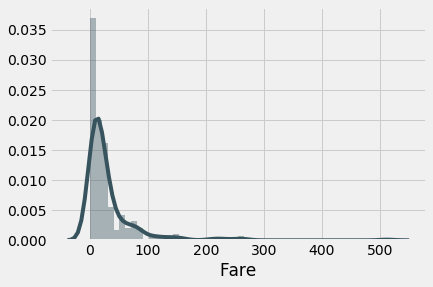

In [2]:
s = sns.distplot(train['Fare'])

The distribution shows a really high skewness (huge tail), so a logarithmic transformation helps in this case to normalize the values. We will make use of anonymous functions here, as we cannot convert those rows with Fare = 0, and from the plot we can see that there might be quite a few.

In [3]:
train["Fare"] = train["Fare"].map(lambda x: np.log(x) if x > 0 else 0)

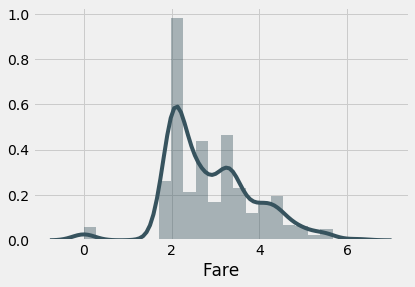

In [4]:
s = sns.distplot(train['Fare'])

The new distribution looks more beautiful. Remember to apply all the changes done to the train set to the test! However, null values appear again:

In [5]:
sum(test['Fare'].isnull())

1

As there is only one missing value, we can just input the mean of the column without any impact on the set.

In [6]:
test.loc[test['Fare'].isnull(),'Fare'] = test['Fare'].mean()
test["Fare"] = test["Fare"].map(lambda x: np.log(x) if x > 0 else 0)